In [2]:
import glob
import numpy as np
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import reduce_mean
from tensorflow.train import AdamOptimizer as adam
from tensorflow.nn import sigmoid_cross_entropy_with_logits as loss
from tensorflow.layers import dense, batch_normalization, conv2d_transpose, conv2d

In [75]:
image_ids = glob.glob('celeb/*')[:100]

crop = (30, 55, 150, 175)
images = [np.array((Image.open(i).crop(crop)).resize((64,64))) for i in image_ids]

for i in range(len(images)):
    images[i] = ((images[i] - images[i].min())/(255 - images[i].min()))
    images[i] = images[i]*2-1
    
images = np.array(images) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


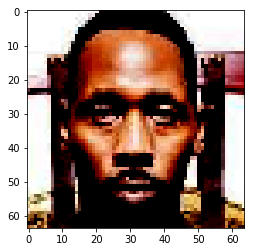

In [45]:
plt.imshow(images[1])

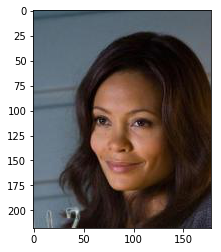

In [107]:
a = Image.open(image_ids[65])
plt.imshow(a)

In [ ]:
def inputs(real_dim, noise_dim):
    
    inputs_real = tf.placeholder(tf.float32, (None, *real_dim), name='input_real')
    inputs_noise = tf.placeholder(tf.float32, (None, noise_dim), name='input_noise')
    
    return inputs_real, inputs_noise

In [6]:
def generator(noise, reuse=False, alpha=0.2, training=True):
    
    with tf.variable_scope('generator', reuse=reuse):
        
        x = dense(noise, 4*4*512)
        x = tf.reshape(x, (-1, 4, 4, 512))
        x = batch_normalization(x, training=training)
        x = tf.maximum(alpha*x, x)
        
        x = conv2d_transpose(x, 256, 5, 2, padding='same')
        x = batch_normalization(x, training=training)
        x = tf.maximum(alpha*x, x)
        
        x = conv2d_transpose(x, 128, 5, 2, padding='same')
        x = batch_normalization(x, training=training)
        x = tf.maximum(alpha*x, x)
        
        x = conv2d_transpose(x, 64, 5, 2, padding='same')
        x = batch_normalization(x, training=training)
        x = tf.maximum(alpha*x, x)
        
        logits = conv2d_transpose(x, 3, 5, 2, padding='same')
        out = tf.tanh(logits)
        
        return out, logits

In [7]:
def discriminator(x, reuse=False, alpha=0.2, training=True):
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        x = conv2d(x, 32, 5, 2, padding='same')
        x = tf.maximum(alpha*x, x)
        
        x = conv2d(x, 64, 5, 2, padding='same')
        x = batch_normalization(x, training=training)
        x = tf.maximum(alpha*x, x)
        
        x = conv2d(x, 128, 5, 2, padding='same')
        x = batch_normalization(x, training=training)
        x = tf.maximum(alpha*x, x)
        
        x = conv2d(x, 256, 5, 2, padding='same')
        x = batch_normalization(x, training=training)
        x = tf.maximum(alpha*x, x)        
        
        flatten = tf.reshape(x, (-1, 4*4*256))
        logits = dense(flatten, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

In [8]:
# hyperparameters

beta1 = 0.5
alpha = 0.2
smooth = 0.9
noise_size = 200
learning_rate = 0.0002
input_shape = (64,64,3)

In [9]:
# buildin the graph

tf.reset_default_graph()

input_real, input_noise = inputs(input_shape, noise_size)

gen_noise, gen_logits = generator(input_noise)

dis_out_real, dis_logits_real = discriminator(input_real)
dis_out_fake, dis_logits_fake = discriminator(gen_noise, reuse=True)

In [10]:
# defining losses

shape = dis_logits_real

dis_loss_real = reduce_mean(loss(logits=dis_logits_real, labels=tf.ones_like(shape*smooth)))

dis_loss_fake = reduce_mean(loss(logits=dis_logits_fake, labels=tf.zeros_like(shape)))                             

gen_loss = reduce_mean(loss(logits=dis_logits_fake, labels=tf.ones_like(shape*smooth)))

dis_loss = dis_loss_real + dis_loss_fake 

In [11]:
# defining optimizers

total_vars = tf.trainable_variables()

dis_vars = [var for var in total_vars if var.name[0] == 'd']
gen_vars = [var for var in total_vars if var.name[0] == 'g']
 
dis_opt = adam(learning_rate=learning_rate, beta1=beta1).minimize(dis_loss, var_list=dis_vars)
gen_opt = adam(learning_rate=learning_rate, beta1=beta1).minimize(gen_loss, var_list=gen_vars)

Epoch 1/100... Discriminator Loss: 4.4522... Generator Loss: 0.0192


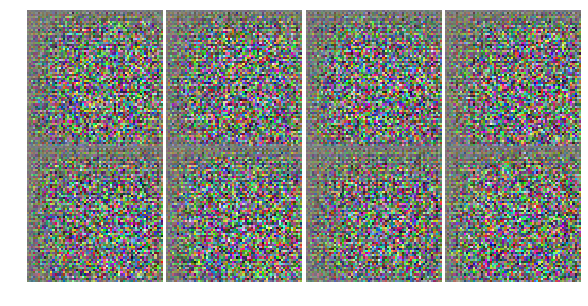

KeyboardInterrupt: 

In [229]:
batch_size = 128
epochs = 100
saver = tf.train.Saver(var_list = gen_vars)

with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    
    for e in range(epochs):
        
        iters = 10000//batch_size
        
        for i in range(1):
            
            batch_images= get_images(batch_size)      
            batch_noise = np.random.uniform(-1, 1, size=(batch_size, noise_size))
            
            sess.run(dis_opt, feed_dict={input_real: batch_images, input_noise: batch_noise})
            sess.run(gen_opt, feed_dict={input_real: batch_images, input_noise: batch_noise})
        
        loss_dis = sess.run(dis_loss, {input_noise: batch_noise, input_real: batch_images})
        loss_gen = gen_loss.eval({input_real: batch_images, input_noise: batch_noise})
            
        print("Epoch {}/{}...".format(e+1, epochs),"Discriminator Loss: {:.4f}...".format(loss_dis),
              "Generator Loss: {:.4f}".format(loss_gen))      
        
        sample_noise = np.random.uniform(-1, 1, size=(8, noise_size))
        gen_samples = sess.run(generator(input_noise, reuse=True, alpha=alpha),
                               feed_dict={input_noise: sample_noise})

        view_samples(-1, gen_samples, 2, 4, (10,5))
        plt.show()
        saver.save(sess, './checkpoints/generator.ckpt')

In [37]:
def view_samples(epoch, samples, nrows, ncols, figsize=(10,10)):
    
    fig, axes = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols)
    
    for ax, img in zip(axes.flatten(), samples[epoch]):
        
        ax.axis('off')
        img = (((img+1)/2)*255).astype(np.uint8)
        im = ax.imshow(img)
   
    plt.subplots_adjust(wspace=0, hspace=0)
    return fig, axes